## 1. Preliminary

### 1.1 Context

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici [les données](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv) et [leur source](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy). Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, **vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

<div class="alert alert-block alert-info">
Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)
</div>

Vous cherchez également à **évaluer l’intérêt de l’"[ENERGY STAR Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what)" pour la prédiction d’émissions**, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :
 1) Réaliser une courte analyse exploratoire.
 2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

> Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 
Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).
Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.


### 1.2 Requirements

In [1]:
package_list = ("pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "mlflow")

In [2]:
!python3 -V

Python 3.10.13


In [3]:
txt = !python3 -m pip freeze
check = lambda i: any([(pack in i) for pack in package_list])
txt = [i for i in txt if check(i)]
txt

['matplotlib==3.8.2',
 'matplotlib-inline==0.1.6',
 'mlflow==2.10.2',
 'numpy @ file:///Users/runner/miniforge3/conda-bld/numpy_1704280780572/work/dist/numpy-1.26.3-cp310-cp310-macosx_11_0_arm64.whl#sha256=f96d0b051b72345dbc317d793b2b34c7c4b7f41b0b791ffc93e820c45ba6a91c',
 'pandas==2.2.0',
 'scikit-learn==1.4.0',
 'seaborn==0.13.2']

### 1.3 Imports

In [4]:
# built in
import os, warnings
import time

# data
import pandas as pd
import numpy as np

# metrics
from sklearn.metrics import mean_squared_error, r2_score

# estimators
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Perceptron
from sklearn.neural_network import MLPRegressor

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## mlflow
import mlflow
import mlflow.sklearn

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# exceptions
from sklearn.exceptions import ConvergenceWarning

# pipeline et preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer



### 1.4 Graphics and option

In [5]:
# warnings.filterwarnings('ignore)
warnings.filterwarnings(action='once')

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='_distutils_hack')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='importlib')

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

<div class="alert alert-block alert-info">
We disable the warnings.</div>

### 1.5 Data

In [1]:
# !tree

In [2]:
# os.listdir()

In [8]:
path="./data/cleaned/"
filename="df_TotalGHGEmissions_0_no_log.csv"

In [9]:
df = pd.read_csv(path+filename)
# df = df.drop(columns='ENERGYSTARScore')
df.head()

,Neighborhood,GroupedPrimaryPropertyTypes,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,DistanceToDowntown,TotalGHGEmissions
0,DOWNTOWN,Bâtiments d'Hébergement,1927.0,1.0,12.0,88434.0,60.0,0.864611,249.98
1,DOWNTOWN,Bâtiments d'Hébergement,1996.0,1.0,11.0,88502.0,61.0,0.907278,295.86
2,DOWNTOWN,Bâtiments d'Hébergement,1969.0,1.0,41.0,759392.0,43.0,1.047606,2089.28
3,DOWNTOWN,Bâtiments d'Hébergement,1926.0,1.0,10.0,61320.0,56.0,1.038057,286.43
4,DOWNTOWN,Bâtiments d'Hébergement,1980.0,1.0,18.0,113580.0,75.0,1.100255,505.01


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 1379 non-null   object 
 1   GroupedPrimaryPropertyTypes  1379 non-null   object 
 2   YearBuilt                    1379 non-null   float64
 3   NumberofBuildings            1379 non-null   float64
 4   NumberofFloors               1379 non-null   float64
 5   PropertyGFABuilding(s)       1379 non-null   float64
 6   ENERGYSTARScore              924 non-null    float64
 7   DistanceToDowntown           1379 non-null   float64
 8   TotalGHGEmissions            1379 non-null   float64
dtypes: float64(7), object(2)
memory usage: 97.1+ KB


## 2. Data Preparation

### 2.1 X & y

In [11]:
X = df.drop(columns="TotalGHGEmissions")
y = df['TotalGHGEmissions']

In [12]:
X.head()

,Neighborhood,GroupedPrimaryPropertyTypes,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,DistanceToDowntown
0,DOWNTOWN,Bâtiments d'Hébergement,1927.0,1.0,12.0,88434.0,60.0,0.864611
1,DOWNTOWN,Bâtiments d'Hébergement,1996.0,1.0,11.0,88502.0,61.0,0.907278
2,DOWNTOWN,Bâtiments d'Hébergement,1969.0,1.0,41.0,759392.0,43.0,1.047606
3,DOWNTOWN,Bâtiments d'Hébergement,1926.0,1.0,10.0,61320.0,56.0,1.038057
4,DOWNTOWN,Bâtiments d'Hébergement,1980.0,1.0,18.0,113580.0,75.0,1.100255


In [13]:
y.head()

0     249.98
1     295.86
2    2089.28
3     286.43
4     505.01
Name: TotalGHGEmissions, dtype: float64

### 2.2 Test train split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=1234)

In [15]:
print(f"We have X_train with shape {X_train.shape} and y_train with shape {y_train.shape}")
print(f"We have X_test with shape {X_test.shape} and y_test with shape {y_test.shape}")

We have X_train with shape (965, 8) and y_train with shape (965,)
We have X_test with shape (414, 8) and y_test with shape (414,)


### 2.3 Pipeline

In [16]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

In [17]:
pipe_trans_num = Pipeline(steps=[('scaler', StandardScaler())])

pipe_trans_cat = Pipeline(steps=[('ohe', OneHotEncoder())])

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', pipe_trans_num, numeric_features),
        ('cat', pipe_trans_cat, categorical_features)
    ])

In [19]:
k_val = 23

model_pipelines = {
    "Dummy": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", DummyRegressor())]), 
    "Linear": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", LinearRegression())]), 
    "Ridge": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", Ridge())]), 
    "Lasso": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", Lasso())]), 
    "ElasticNet": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", ElasticNet())]),
    "RandomForest": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", RandomForestRegressor())]),
    "GradientBoosting": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", GradientBoostingRegressor())]),
    "MLP": Pipeline([("preprocessor", preprocessor), ("imputer", KNNImputer(n_neighbors=k_val)), ("model", MLPRegressor())])
}


## 3. Modelisation

In [20]:
# Configurer MLflow
mlflow.set_experiment('Regression_Models_gas_v1_no_log')

# Initialiser le DataFrame des résultats
results_df = pd.DataFrame(columns=['Model Name', 'Best Parameters', 'MSE Train', 'MSE Test', 'R2 Train', 'R2 Test', 'Best CV R2 Test', 'Fit Time'])

def train_eval_model(model, X_train, y_train, X_test, y_test, model_name, best_params=None, best_cv_score=None):
    # Set model parameters if provided
    if best_params:
        model.set_params(**best_params)

    # Mesurer le temps de début
    start_time = time.time()
    # Entraîner le modèle
    model.fit(X_train, y_train)
    # Mesurer le temps de fin et calculer le temps de fitting
    fit_time = time.time() - start_time

    # Prédictions sur les données d'entraînement et de test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des métriques de performance
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Enregistrement de la performance du modèle avec MLflow
    with mlflow.start_run(run_name=f"{model_name}"):
        if best_params:
            mlflow.log_params(best_params)
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("mse_test", mse_test)
        mlflow.log_metric("r2_train", r2_train)
        mlflow.log_metric("r2_test", r2_test)
        if best_cv_score is not None:
            mlflow.log_metric("best_cv_r2_test", best_cv_score)
        mlflow.sklearn.log_model(model, f"model_{model_name}")

        print(f"{model_name} - MSE Train: {mse_train}, MSE Test: {mse_test}, R2 Train: {r2_train}, R2 Test: {r2_test}")

    # Plotting the predicted vs real values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Comparison of Real and Predicted Values for {model_name}')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
    plt.savefig(f'predicted_vs_real_{model_name}_gas_v1_no_log.png')
    plt.show()
    
    
    # Calcul des résidus
    residuals = y_test - y_test_pred

    # Tracer le graphique des résidus
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for {model_name}')
    plt.axhline(y=0, color='k', linestyle='--')  # Ligne horizontale à zéro
    plt.savefig(f'residual_plot_{model_name}_gas_v1_no_log.png')
    plt.show()
    
    # Tracer l'histogramme des résidus
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Residuals for {model_name}')
    plt.savefig(f'residuals_histogram_{model_name}_gas_v1_no_log.png')
    plt.show()

    # Tracer le tracé KDE des résidus
    plt.figure(figsize=(10, 6))
    sns.kdeplot(residuals, shade=True)
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title(f'KDE Plot of Residuals for {model_name}')
    plt.savefig(f'residuals_kde_{model_name}_gas_v1_no_log.png')
    plt.show()


    # Enregistrement des résultats dans le DataFrame
    global results_df
    new_row = pd.DataFrame([{
        'Model Name': model_name,
        'Best Parameters': best_params,
        'MSE Train': mse_train,
        'MSE Test': mse_test,
        'R2 Train': r2_train,
        'R2 Test': r2_test,
        'Best CV R2 Test': best_cv_score,
        'Fit Time': fit_time
    }])
    results_df = pd.concat([results_df, new_row], ignore_index=True)


In [21]:
# Définition des espaces de paramètres pour chaque modèle
param_grids = {
    "Dummy": {'model__strategy': ['mean', 'median']},
    "Linear": {},
    "Ridge": {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    "Lasso": {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    "ElasticNet": {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'model__l1_ratio': [0.2, 0.5, 0.8]},
    "RandomForest": {'model__n_estimators': [50, 100, 200], 'model__max_depth': [2, 3, 5, 10], 'model__min_samples_split': [10, 20], 'model__min_samples_leaf':[10, 20]},
    "GradientBoosting": {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__max_depth': [2, 3, 5, 10], 'model__min_samples_split': [10, 20], 'model__min_samples_leaf':[10, 20]},
    "MLP": {'model__hidden_layer_sizes': [(10, 10), (50, 50), (25, 25, 25)], 'model__activation': ['tanh', 'relu'], 'model__max_iter': [1000]}
}

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Dummy - MSE Train: 348553.5239921806, MSE Test: 461623.51310125424, R2 Train: 0.0, R2 Test: -0.001012565829947798


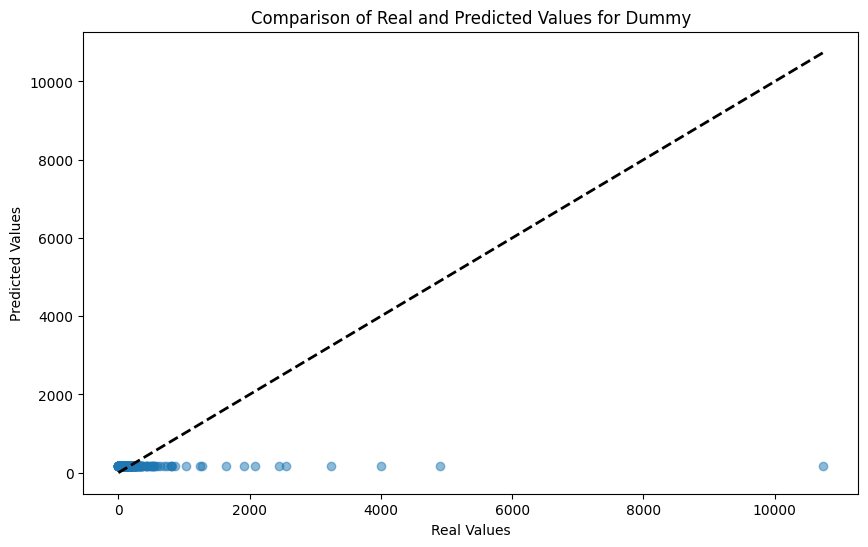

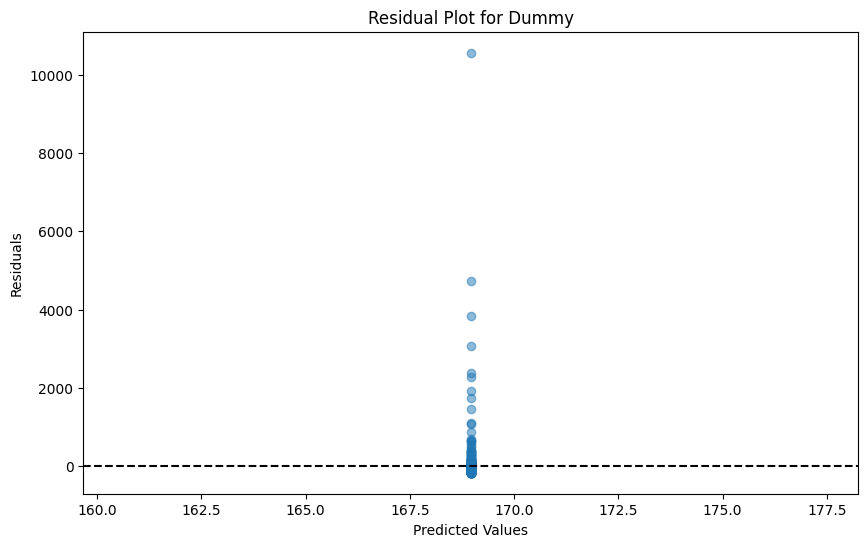

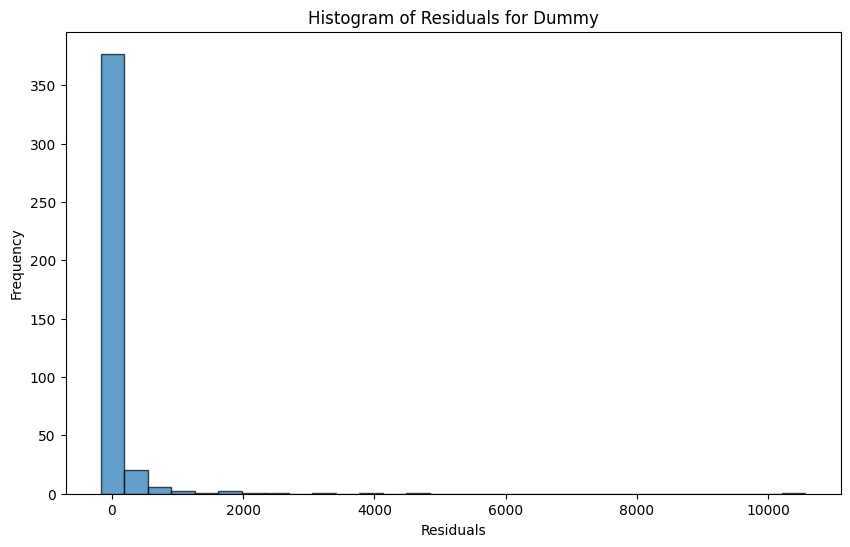

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


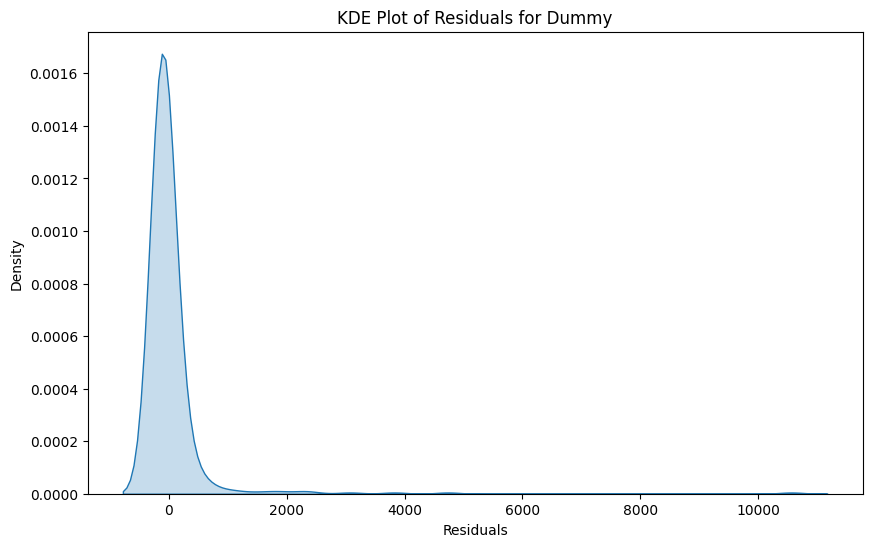

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Linear - MSE Train: 143278.59671243146, MSE Test: 247266.74316518687, R2 Train: 0.588933730833128, R2 Test: 0.4638117210335708


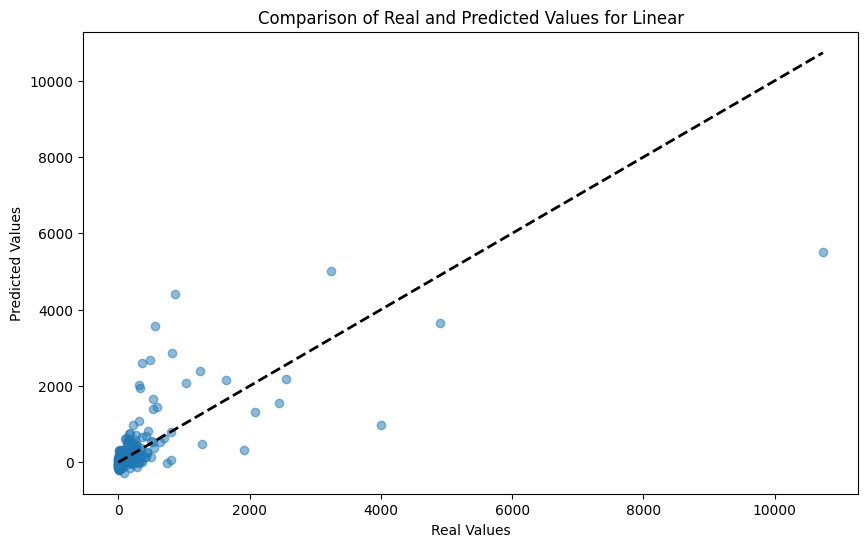

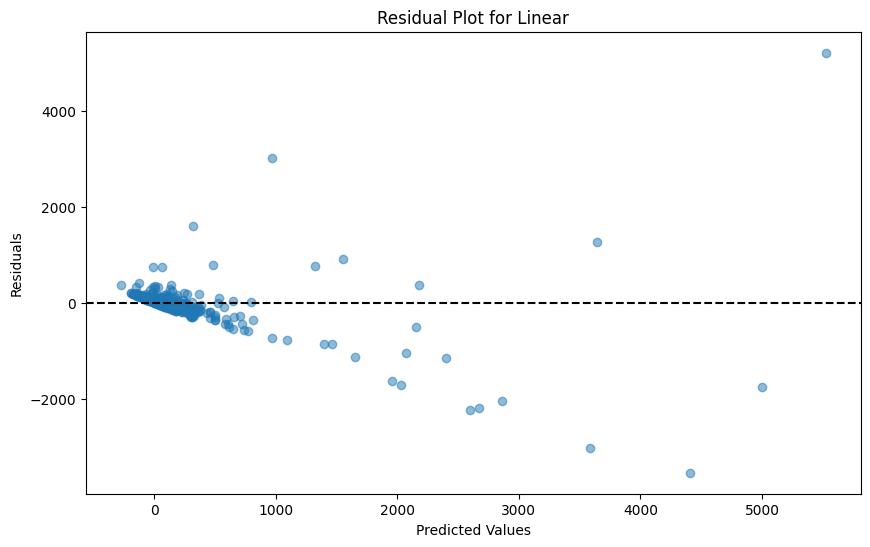

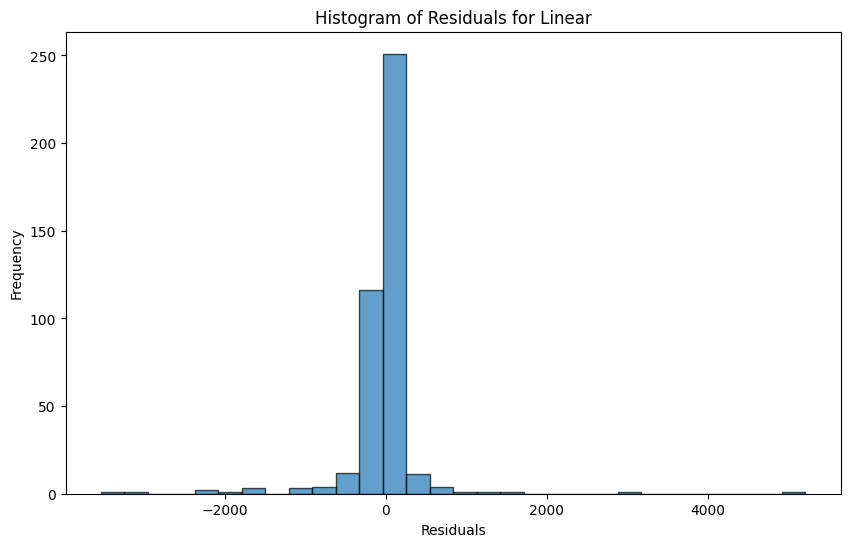

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


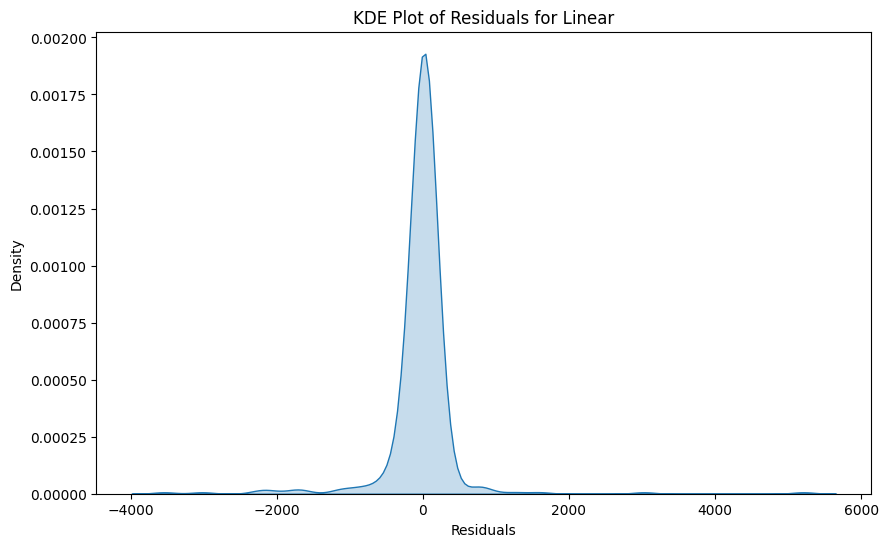

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Ridge - MSE Train: 143415.7248147223, MSE Test: 252164.490387226, R2 Train: 0.588540310331392, R2 Test: 0.4531911473964464


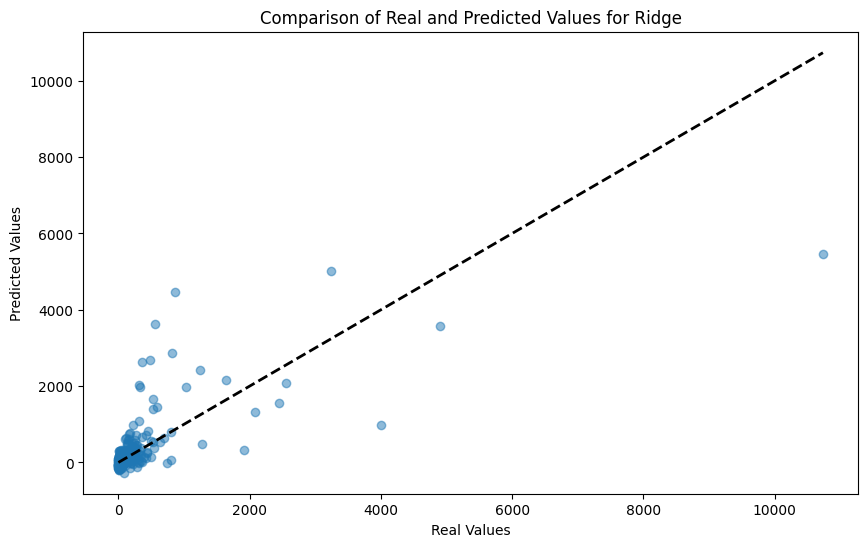

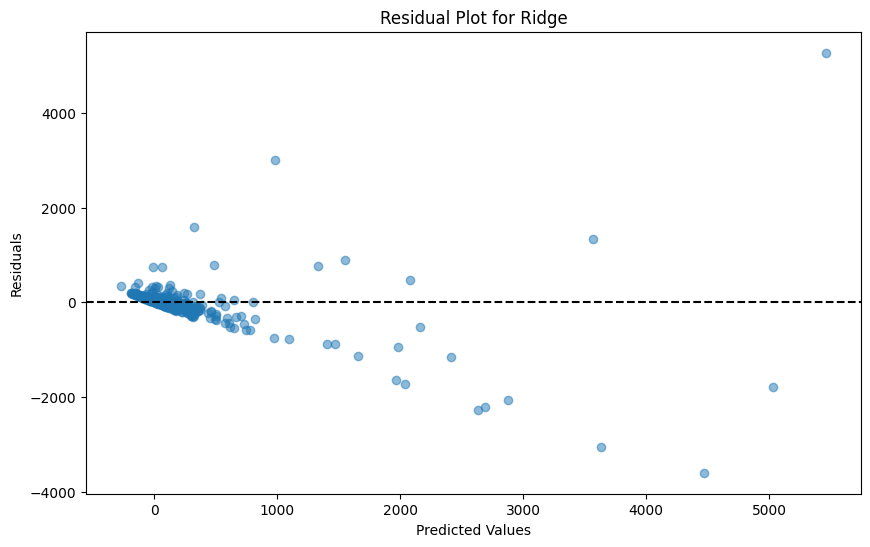

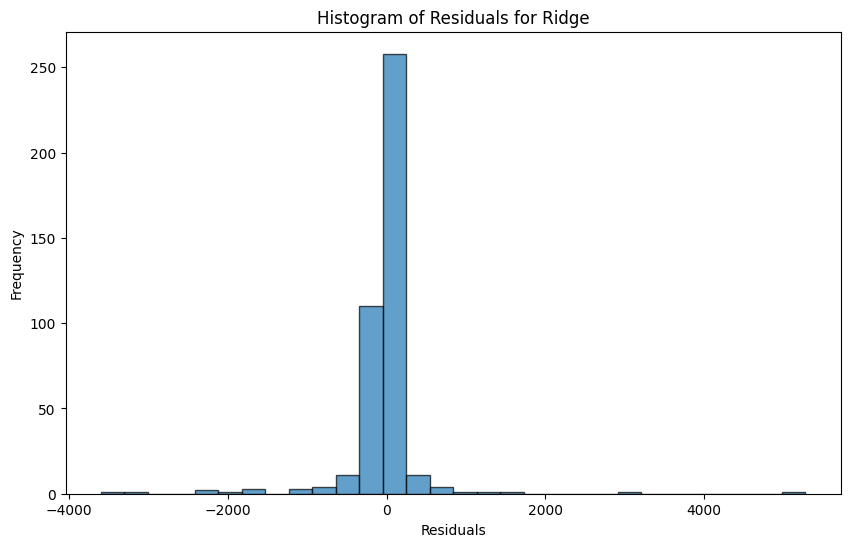

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


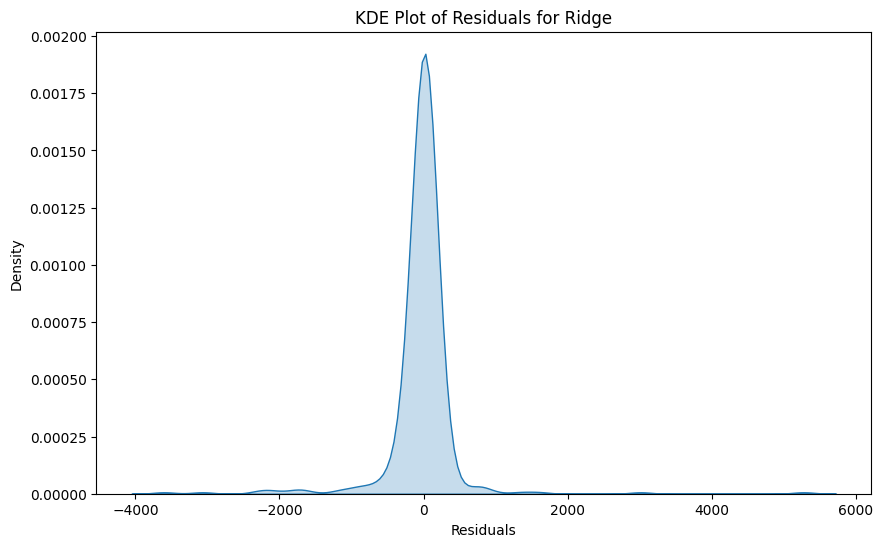

Lasso - MSE Train: 143574.21010607053, MSE Test: 249326.27909030957, R2 Train: 0.5880856160579474, R2 Test: 0.45934569778667034


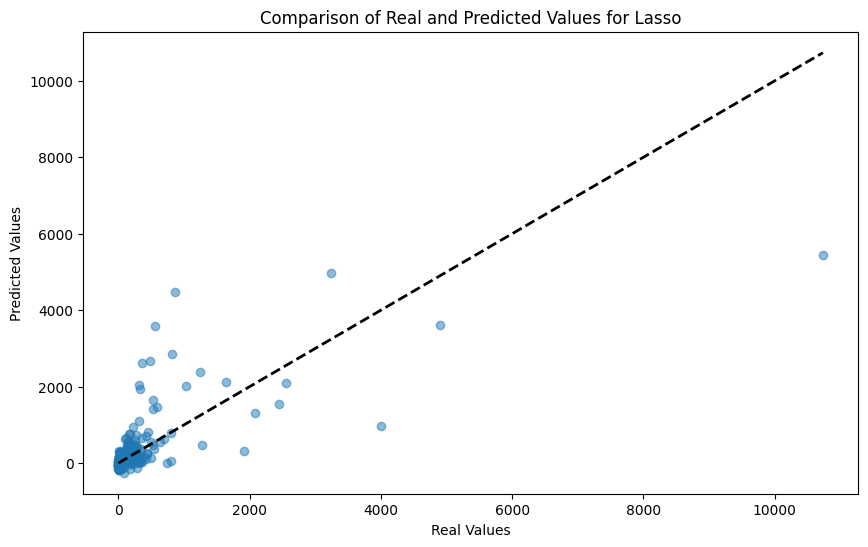

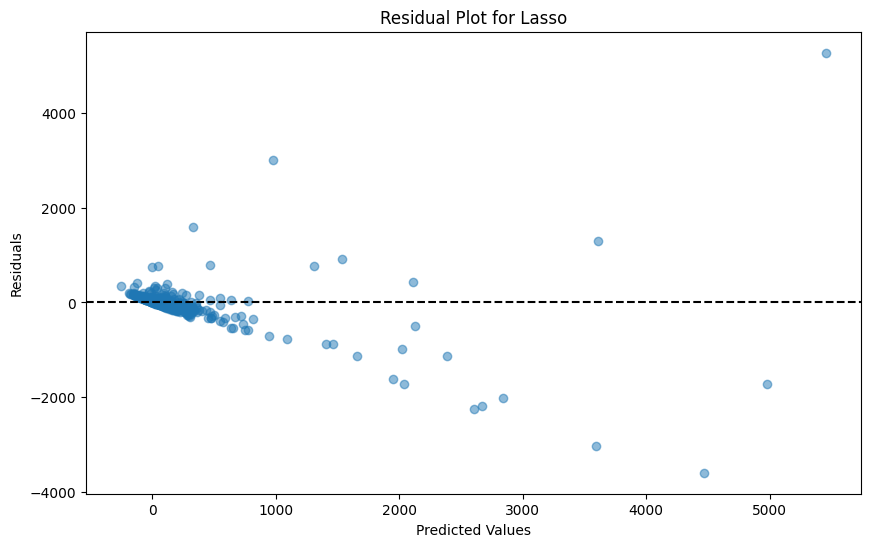

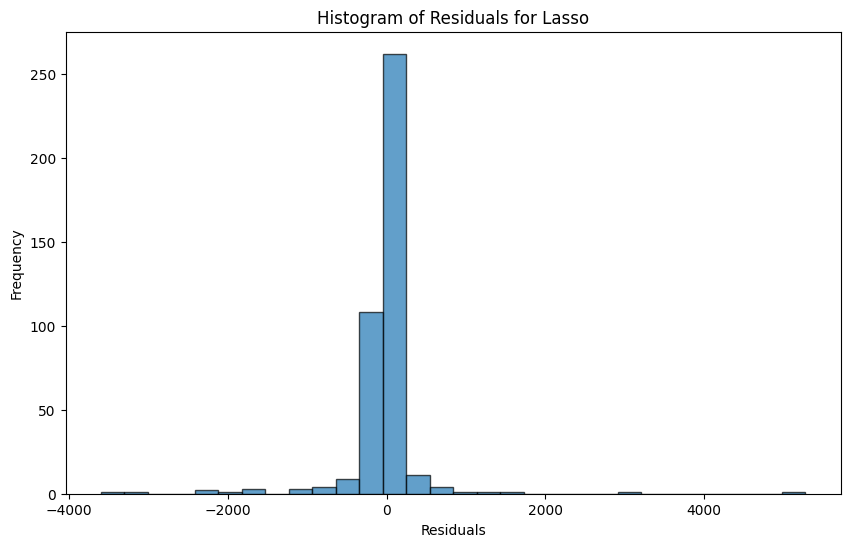

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


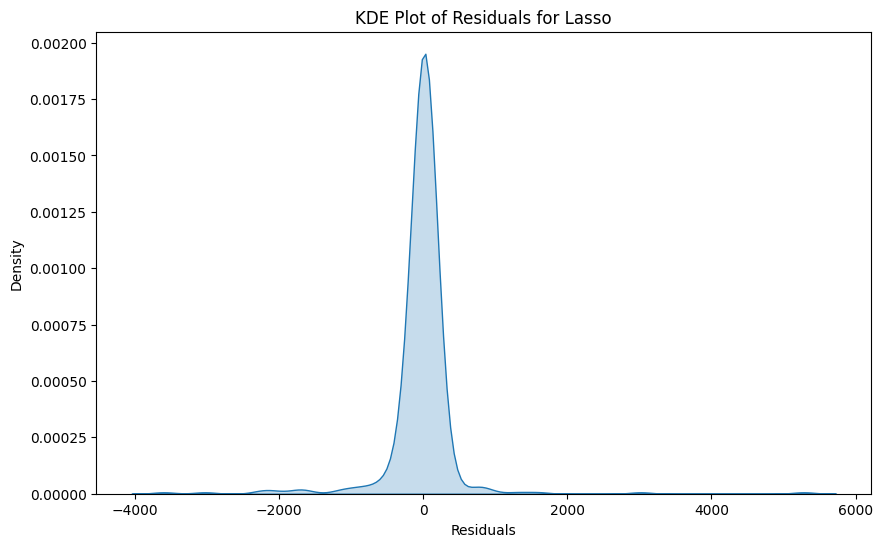

ElasticNet - MSE Train: 266099.27294902713, MSE Test: 348386.4819813958, R2 Train: 0.2365612319702245, R2 Test: 0.2445375152453031


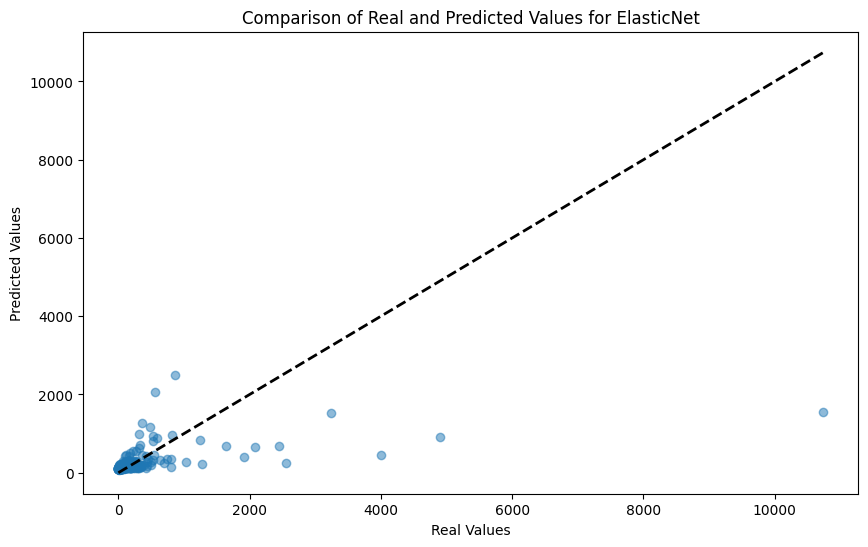

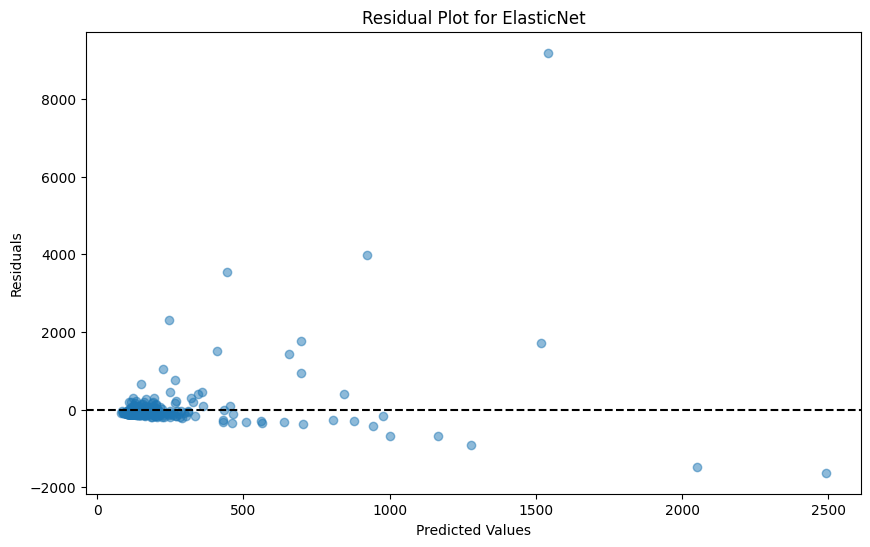

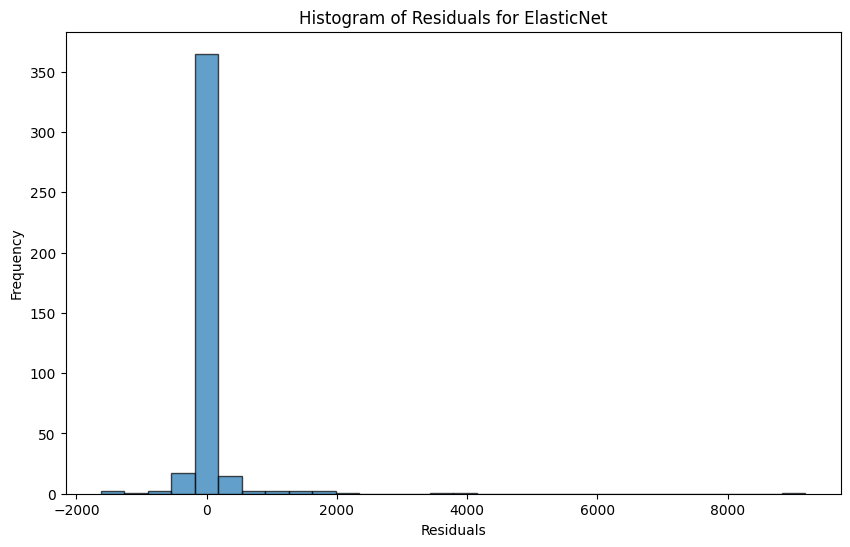

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


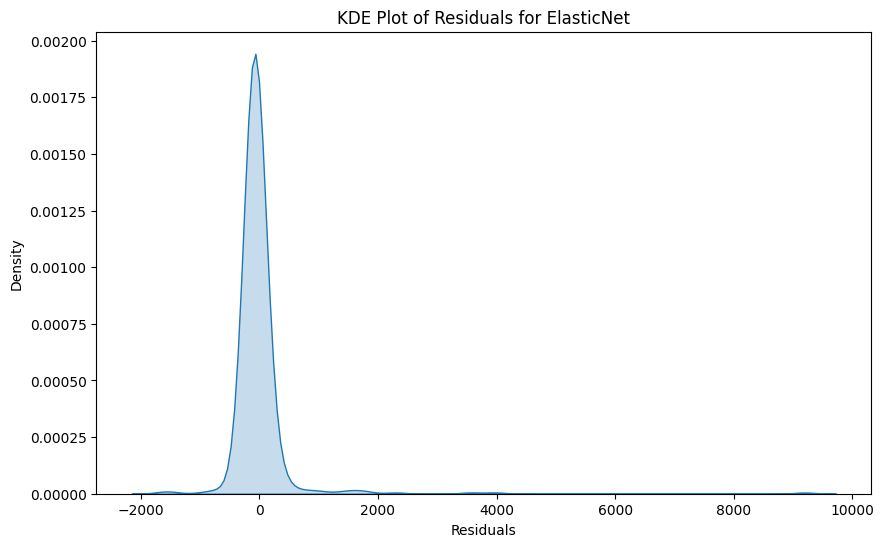

RandomForest - MSE Train: 195468.3165510064, MSE Test: 251392.9774010555, R2 Train: 0.43920143365013997, R2 Test: 0.45486414318617396


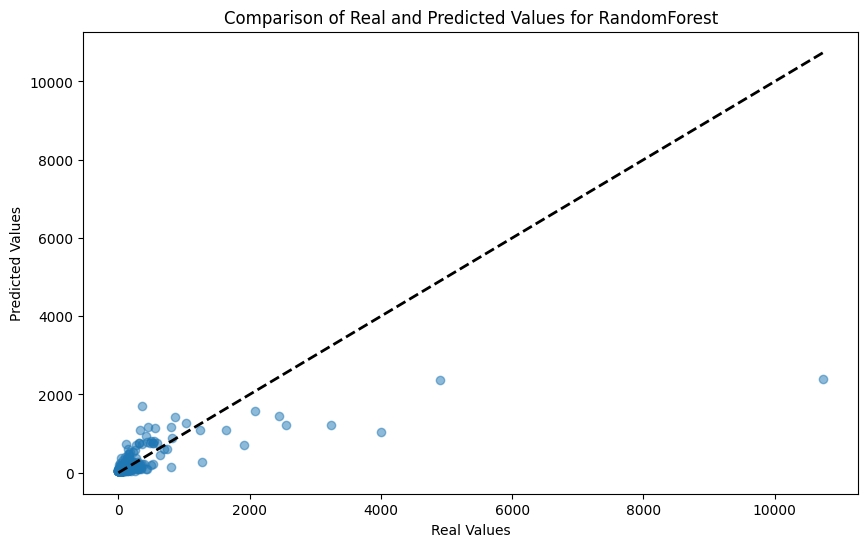

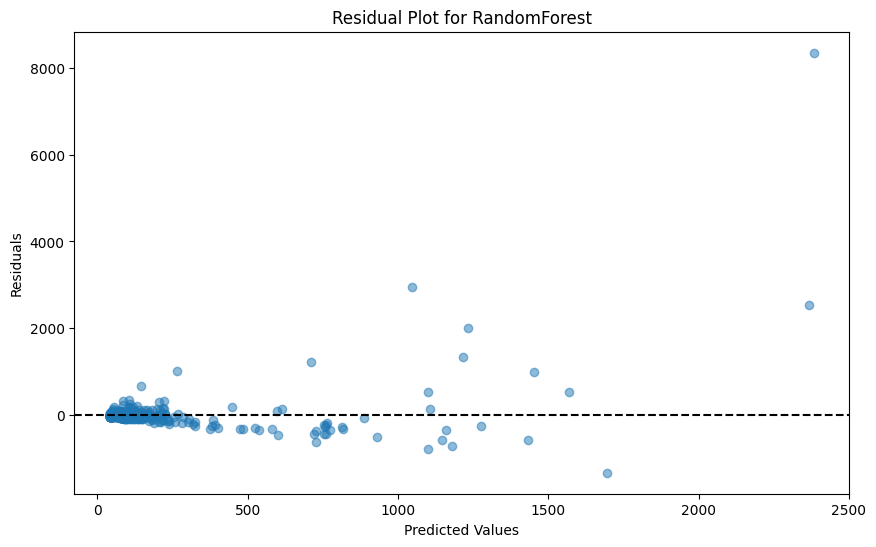

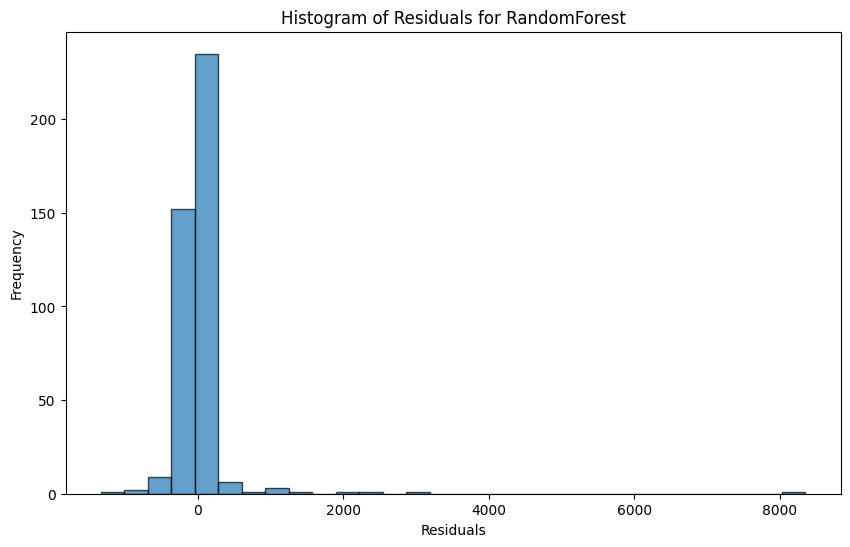

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


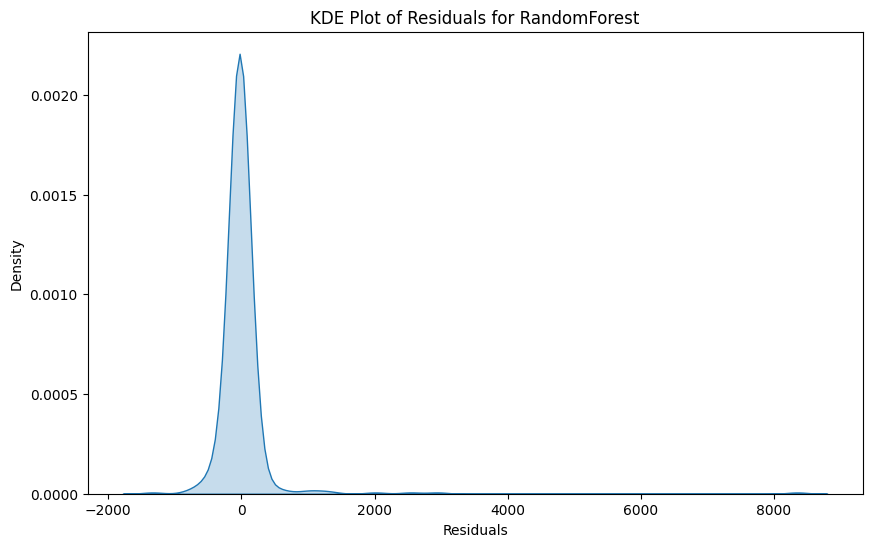

GradientBoosting - MSE Train: 37157.614515067406, MSE Test: 84220.11209074102, R2 Train: 0.8933948103881428, R2 Test: 0.8173719749844142


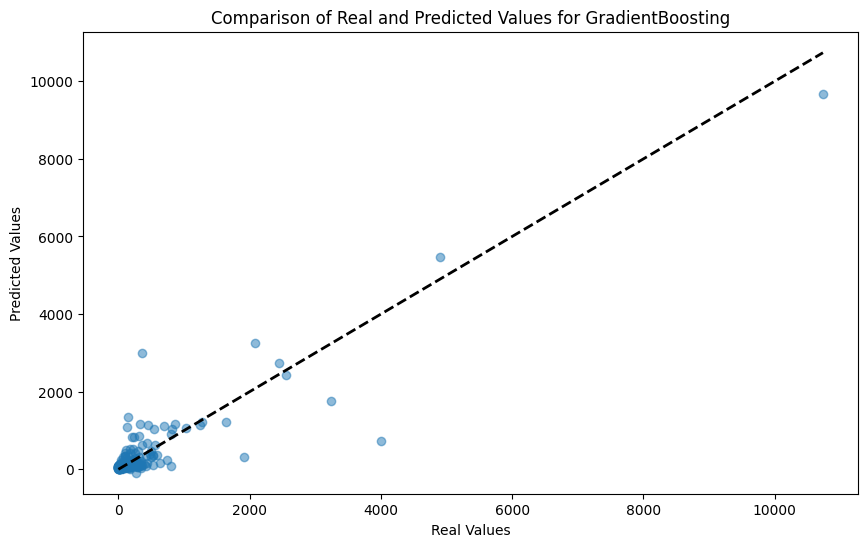

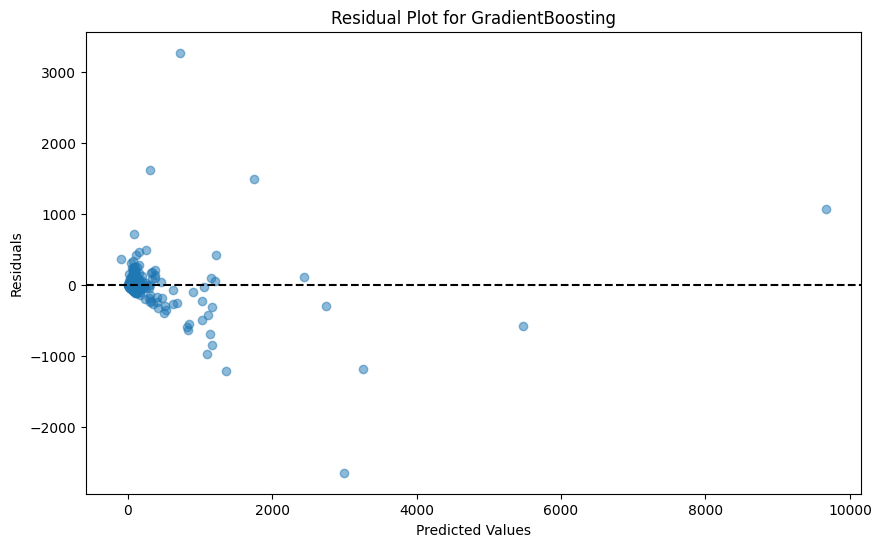

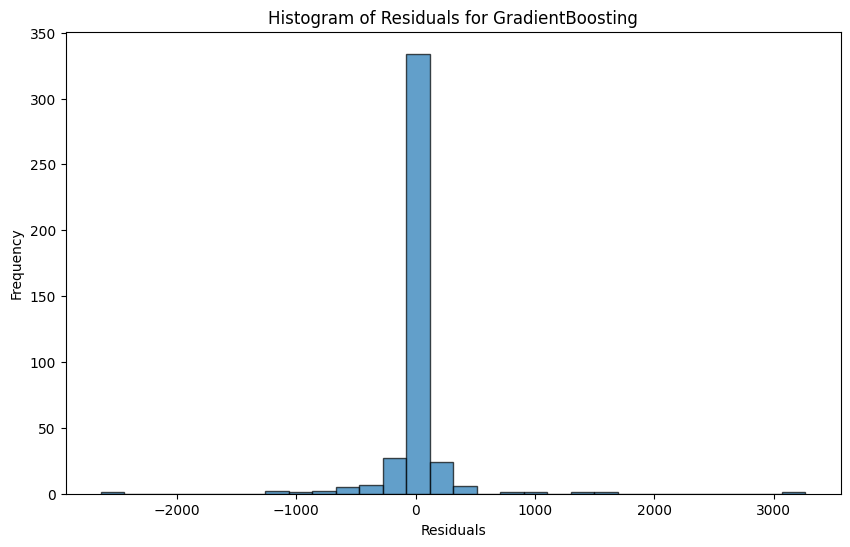

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


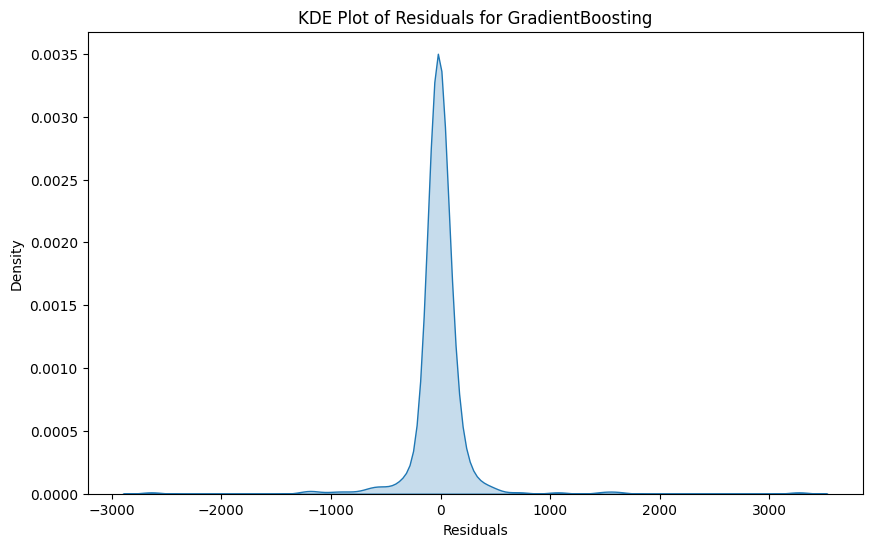

MLP - MSE Train: 11497.862542228819, MSE Test: 272695.91812914226, R2 Train: 0.9670126343565909, R2 Test: 0.4086695479094208


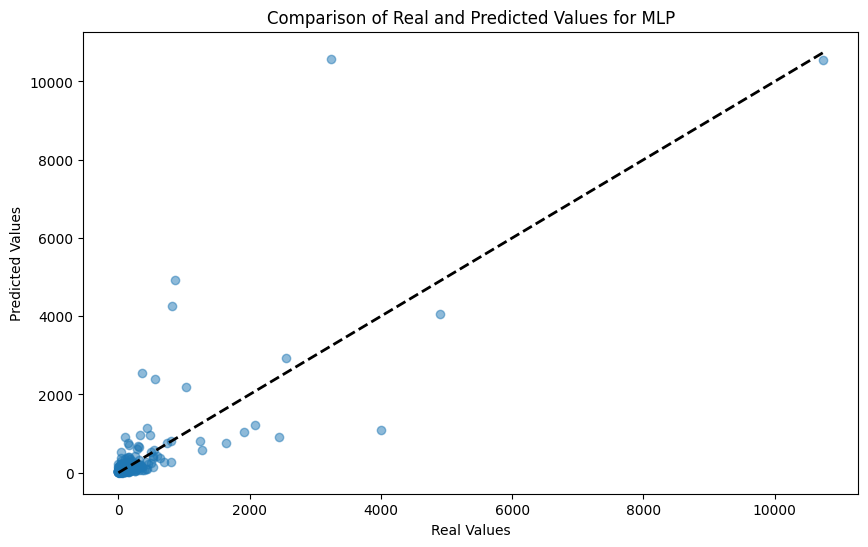

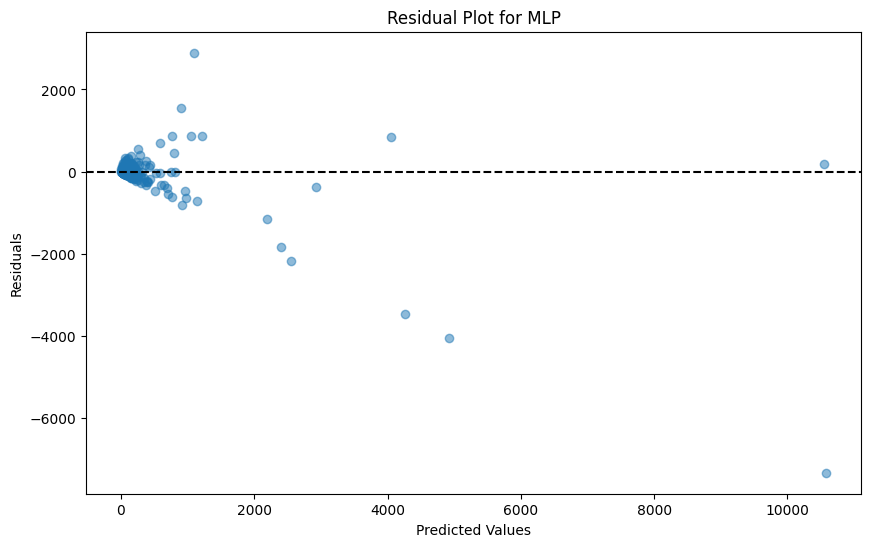

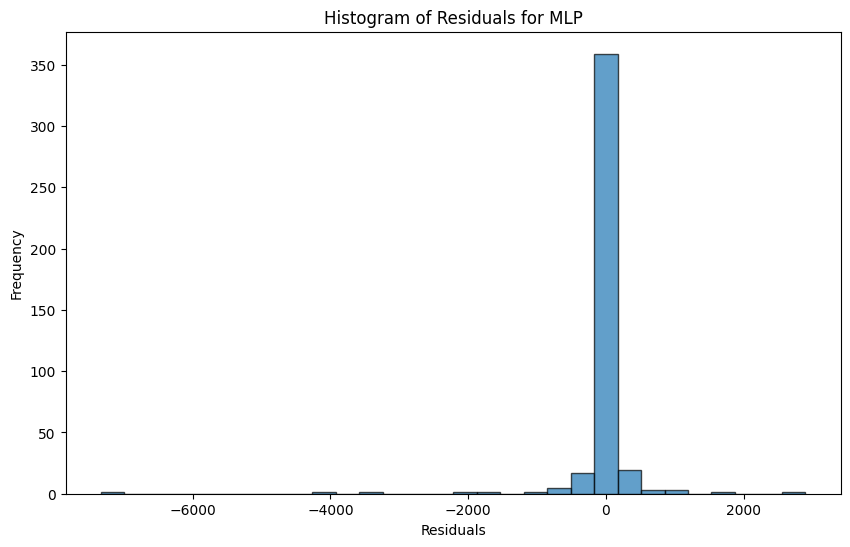

/var/folders/bz/8k97qs097cl71k8j24r6d83c0000gn/T/ipykernel_46166/3702692924.py:78: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


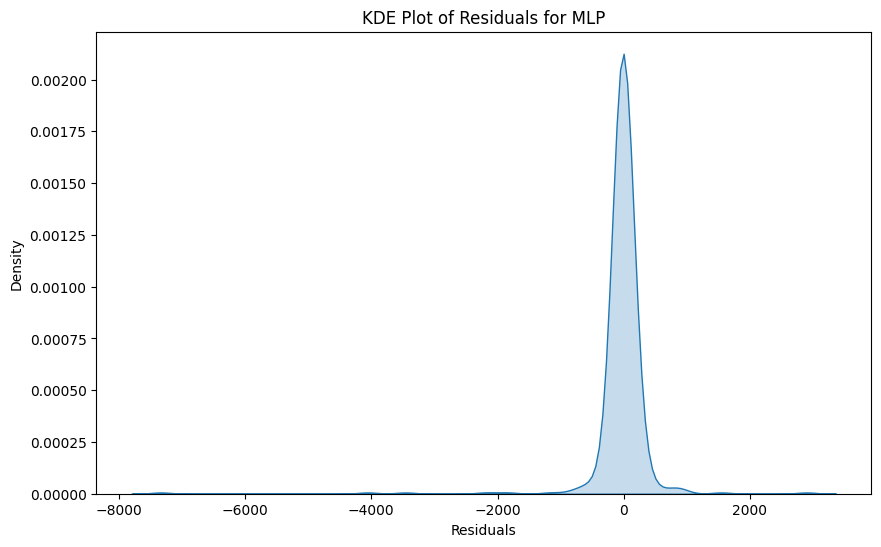

,Model Name,Best Parameters,MSE Train,MSE Test,R2 Train,R2 Test,Best CV R2 Test,Fit Time
0,Dummy,{'model__strategy': 'mean'},348553.523992,461623.513101,0.000000,-0.001013,-0.005736,0.022573
1,Linear,None,143278.596712,247266.743165,0.588934,0.463812,NaN,0.033544
2,Ridge,{'model__alpha': 1},143415.724815,252164.490387,0.588540,0.453191,0.118225,0.066097
3,Lasso,{'model__alpha': 1},143574.210106,249326.279090,0.588086,0.459346,0.123172,0.029036
4,ElasticNet,"{'model__alpha': 10, 'model__l1_ratio': 0.8}",266099.272949,348386.481981,0.236561,0.244538,0.226467,0.054908
5,RandomForest,"{'model__max_depth': 5, 'model__min_samples_le...",195468.316551,251392.977401,0.439201,0.454864,0.325586,0.137071
6,GradientBoosting,"{'model__learning_rate': 0.1, 'model__max_dept...",37157.614515,84220.112091,0.893395,0.817372,0.453555,0.326606
7,MLP,"{'model__activation': 'relu', 'model__hidden_l...",11497.862542,272695.918129,0.967013,0.408670,0.526452,2.511417


In [22]:
# Recherche des meilleurs hyperparamètres et enregistrement du meilleur score de validation croisée
best_params = {}
best_cv_scores = {}

for model_name, param_grid in param_grids.items():
    model = model_pipelines[model_name]

    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', verbose=1)
        grid_search.fit(X_train, y_train)
        best_params[model_name] = grid_search.best_params_
        best_cv_scores[model_name] = max(grid_search.cv_results_['mean_test_score'])
    else:
        best_params[model_name] = None
        best_cv_scores[model_name] = None

# Entraînement, évaluation et enregistrement des meilleurs modèles
for model_name, params in best_params.items():
    model = model_pipelines[model_name]

    train_eval_model(model, X_train, y_train, X_test, y_test, model_name, params, best_cv_scores[model_name])

# Afficher les résultats consolidés
results_df.head(10)

In [23]:
# Retrieve the current MLflow experiment name
mlflow_experiment_name = mlflow.get_experiment_by_name('Regression_Models_gas_v1_no_log').name

# Construct a filename using the experiment name
filename = f"{mlflow_experiment_name}_results.csv"

# Save the DataFrame
results_df.to_csv(filename, index=False)
print(f"Results saved as {filename}")

Results saved as Regression_Models_gas_v1_no_log_results.csv
